In [199]:
using Plots,LinearAlgebra,Distributions,Random,Zygote

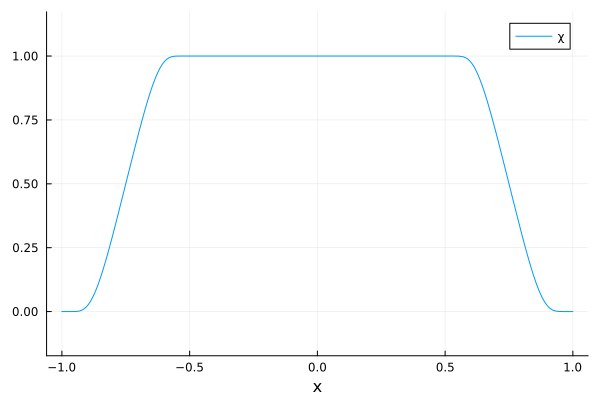

In [200]:
f(t) = (t <= 0) ? zero(t) : exp(-inv(t))
g(t) = f(t) / (f(t) + f(1-t))
χ(t) =  g(2(t+1)) + g(2(1-t))-1 # symmetric bump function 

plot(χ,-1,1,aspectratio = 1,label="χ",xlabel="x")

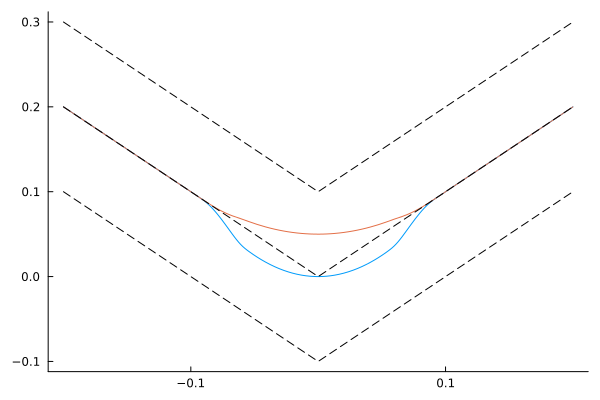

In [201]:
abs_pε(x,ε) = (abs(x)<ε) ? abs(x)+(ε+(x^2-ε^2)/2ε-abs(x))*χ(x/ε)  : abs(x)
abs_mε(x,ε) = (abs(x)<ε) ? abs(x)+(ε*(x/ε)^2-abs(x))*χ(x/ε)  : abs(x)

ε=0.1

plot(x->abs_mε(x,ε),-2ε,2ε,label="")
plot!(x->abs_pε(x,ε),label="")
# plot!(abs)
plot!(x->abs(x),color=:black,linestyle=:dash,label="")
plot!(x->abs(x)+ε,color=:black,linestyle=:dash,label="")
plot!(x->abs(x)-ε,color=:black,linestyle=:dash,label="",grid=false,xticks=[-ε,ε])

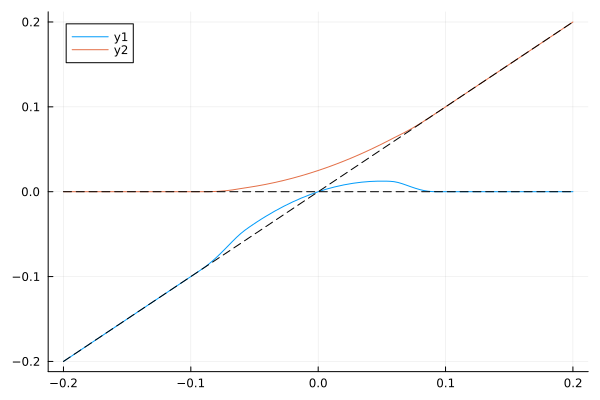

In [4]:
minε(x,y,ε) = (x+y-abs_mε(x-y,ε))/2
maxε(x,y,ε) = (x+y+abs_pε(x-y,ε))/2

plot(x->minε(x,0,ε),-2ε,2ε)
plot!(x->maxε(x,0,ε))
plot!(x->max(x,0),color=:black,linestyle=:dash,label="")
plot!(x->min(x,0),color=:black,linestyle=:dash,label="")

In [212]:
const α = -1.5
const R = 6.0
const ρ = 1.0
const σ = 0.1

const ε0 = 1/3.1
const ε1 = ε0/3

const u = normalize([0,1])


2-element Vector{Float64}:
 0.0
 1.0

In [213]:
seed = 2023
rng = Xoshiro(seed)

N_modes = 4
fs = rand(rng,[sin,cos],N_modes)
coeffs = randn(rng,N_modes)
x_coeffs = N_modes*randn(rng,N_modes)
y_coeffs = N_modes*randn(rng,N_modes)

function perturbation(x,y)
    s = 0.0

    for i=1:N_modes
        f = fs[i]
        a = coeffs[i]
        b = x_coeffs[i]
        c = y_coeffs[i]
        
        s+= a*f(b*x+c*y)
    end

    return s/sqrt(N_modes)
end

a(X) =α - u'X - σ * perturbation(X[1],X[2]) # ∂Ω = zero-level-set
b(X) = R-norm(X)
c(X) =  α+ρ-u'X

a(x,y)=a([x,y]);b(x,y) = b([x,y]);c(x,y) = c([x,y])

c (generic function with 2 methods)

In [215]:
function newton(f,X0,niter;tol=1e-13)
    x = copy(X0)
    for i=1:niter
        x -= first(jacobian(f,x)) \ f(x)

        if maximum(abs,f(x)) < tol
            return x
        end
    end
    
    return x
end

circle_domain(X) = [a(X),b(X)]
circle_plane(X) = [b(X),c(X)]

X_cpA = newton(circle_plane,[-6.0,1.0],1000)
X_cpB = newton(circle_plane,[6.0,-1.0],1000)
X_cdA = newton(circle_domain,[-6.0,-0.5],1000)
X_cdB = newton(circle_domain,[5.5,-1.5],1000)

intersections = [X_cpA X_cpB X_cdA X_cdB]

2×4 Matrix{Float64}:
 -5.97913   5.97913  -5.83146   5.79431
 -0.5      -0.5      -1.41211  -1.55757

In [216]:
# perturbation(x,y) = (-sin(1.1(x-2.3y))+cos(2.5(1.7x-y))-sin(4.7(x-0.3y)))/3

yprime(X) = norm(X-u'X*u)

hard_dist(X) = max(a(X),min(b(X),c(X)))
soft_dist(X) = maxε(a(X),minε(b(X),c(X),ε0),ε0)

hard_dist(x,y) = hard_dist([x,y]) ; soft_dist(x,y) = soft_dist([x,y])
gradnorm(X) = norm(first(gradient(soft_dist,X)))

soft_dist_shifted(X) = soft_dist(X)  -ε1*χ(yprime(X)/sqrt((R-ε0)^2-(α+ρ)^2))
soft_dist_shifted(x,y) = soft_dist_shifted([x,y])

soft_dist_shifted (generic function with 2 methods)

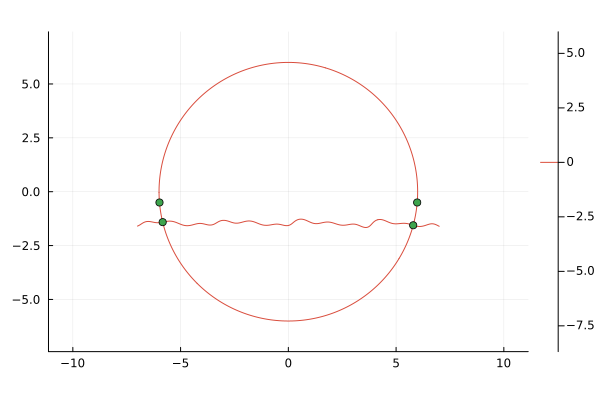

In [217]:
xrange=range(-7,7,1000)
contour(xrange,xrange,a,levels=[0],aspectratio=1)
contour!(xrange,xrange,b,levels=[0])
scatter!(intersections[1,:],intersections[2,:],label="")

In [218]:
function walk_level_set(f,X0,ds,xmax,maxiter=200000)
    normals = Vector{Float64}[]
    points = Vector{Float64}[]
    X = copy(X0)

    for i=1:maxiter
        # (i%1000 == 0) && print(first(X))
        push!(points,copy(X))
        grad = first(gradient(f,X))
        push!(normals,grad/norm(grad))

        a,b=grad
        T = [-b,a]
        T /= norm(T)

        h(Z) = [f(Z),norm(X-Z)-ds]
        X = newton(h,X+ds*T,15)

        if (X[1]>xmax) || (norm(X-X0)<ds/2)
            break
        end
    end

    return reduce(hcat,points),reduce(hcat,normals)
end


walk_level_set (generic function with 2 methods)

In [219]:
x0 = -10
h(X) = [a(X),X[1]-x0]
X0 = newton(h,[x0,0.1],100)
points_soft,normals_soft = walk_level_set(soft_dist,X0,0.0005,10)
points_domain,normals_domain = walk_level_set(a,X0,0.0005,10)

([-10.0 -9.999506865397297 … 9.999287316273556 9.99975307762725; -1.3947841407599106 -1.3948667135376152 … -1.6242276804085651 -1.6240458388252983], [-0.16482317165123772 -0.16546743758903937 … 0.36352194848654285 0.36384416366514055; -0.986323132693757 -0.9862152539368458 … -0.9315856337280795 -0.9314598351871188])

In [221]:
plot!(pl,xlims = (4.5,7),ylims=(-2.5,-0.5))
savefig("detail.pdf")

"/home/nblassel/Documents/QSDs.jl/document/semiclassic/plot_scripts/detail.pdf"

In [222]:
plot(pl)
savefig("full.pdf")

"/home/nblassel/Documents/QSDs.jl/document/semiclassic/plot_scripts/full.pdf"

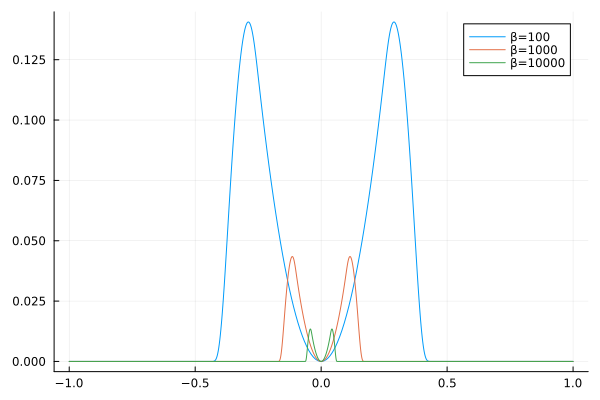

In [102]:
p,q = 0.01,0.01

δ(β) = β^(p-0.5)*sqrt(log(β))
γ(β) = inv(β^q*sqrt(β))

∂Ω(x;β) = χ(x/2δ(β))*x^2*(γ(β))/(δ(β)^2)

pl_cusp = plot()
for β=[100,1000,10000]
    plot!(pl_cusp,x->∂Ω(x;β=β),-1,1,label="β=$β")
end

pl_cusp

In [187]:
κmax = -Inf
argκmax = -1
_,k = size(normals_domain)
flips = Int[]
ds = 0.0005

for j=1:k-1
     n,np1 = normals_domain[:,j],normals_domain[:,j+1]

     z = n[1]+im*n[2]
     zp1 = np1[1]+im*np1[2]
     κ = abs(angle(zp1/z))/ds
     if κ>κmax
          κmax=κ
          argκmax = j
     end
end
κmax

3.077944146615745

In [136]:
flips

Int64[]

In [142]:
atan(normals_domain[:,argκmax+1]...)

3.140733954560461

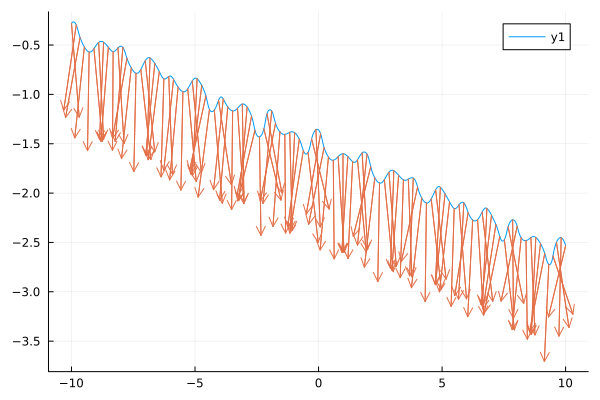

In [134]:
every = 200
A,B,C,D = points_domain[1,:],points_domain[2,:],normals_domain[1,:],normals_domain[2,:]
plot(A,B)
quiver!(A[1:every:end],B[1:every:end],quiver=(C[1:every:end],D[1:every:end]))

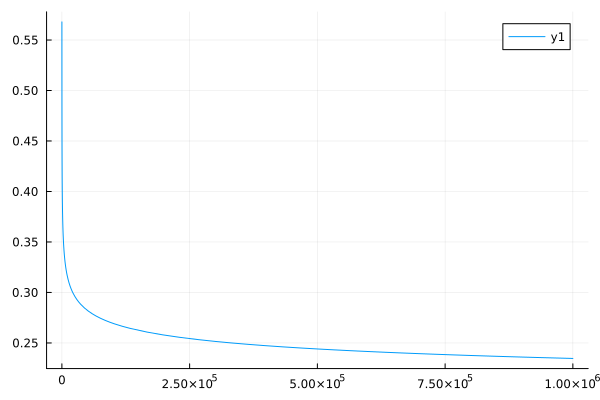

In [81]:
plot(β->log(log(β))/(log(β)-log(log(β))),10,1e6)